In [1]:
using Pkg
Pkg.activate(".")
Pkg.add(url="https://github.com/zsteve/OptimalTransport.jl", rev="symmetric_quad")

  Activating project at `~/Projects/qrot/notebooks`
    Updating git-repo `https://github.com/zsteve/OptimalTransport.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Projects/qrot/notebooks/Project.toml`
  No Changes to `~/Projects/qrot/notebooks/Manifest.toml`


In [17]:
using OptimalTransport
using Distances
using Distances: pairwise
using Plots
using StatsBase
using GLM
using DataFrames
using LinearAlgebra

In [18]:
d = 2 # 2, 3, 4

2

In [9]:
# d-sphere
function get_plot(N)
    # θs = range(-π, π; length = N)
    # X = mapreduce(x -> [cos(x), sin(x)], hcat, θs)
    X = randn(d, N)
    X ./= reshape(map(norm, eachcol(X)), 1, :)
    @info size(X)
    C = pairwise(SqEuclidean(), X)
    # C /= mean(C)
    εvals = 10 .^range(6, -2; length = 100)
    μ = fill(1/size(X, 2), size(X, 2))
    function dualpotentials(ε)
        # @info ε
        solver = OptimalTransport.build_solver(μ, C, ε, OptimalTransport.SymmetricQuadraticOTNewton(δ = 1e-5); maxiter = 100)
        OptimalTransport.solve!(solver)
        solver.cache.u
    end
    uvals = map(x -> dualpotentials(x), εvals)
    umeans = map(mean, uvals)
    # df1 = DataFrame(logu = log10.(umeans[εvals .< 0.05]), logeps = log10.(εvals[εvals .< 0.05]))
    # fit1 = lm(@formula(logu ~ logeps), df1)
    df2 = DataFrame(logu = log10.(umeans[εvals .> 25]), logeps = log10.(εvals[εvals .> 25]))
    fit2 = lm(@formula(logu ~ logeps), df2)
    plt=scatter(log10.(εvals), log10.(umeans); markersize = 1, alpha = 0.25, label = "data", legend = :topleft, title = "N = $N")
    # plot!(plt, df1.logeps, predict(fit1); label = "α = $(coef(fit1)[2])")
    plot!(plt, df2.logeps, predict(fit2); label = "α = $(round(coef(fit2)[2]; digits = 3))")
    # hline!(plt, [log10.(Cthresh), ]; label = "u_thresh")
    plt
end

get_plot (generic function with 1 method)

In [10]:
Ns = [1_000, ]

1-element Vector{Int64}:
 1000

In [8]:
plots_all = map(x -> get_plot(x), Ns)

[ Info: (2, 1000)
┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-5, 50) (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/hPH0U/src/quadratic_newton_symm.jl:136
┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-5, 50) (100/100): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/hPH0U/src/quadratic_newton_symm.jl:136


LoadError: InterruptException:

In [28]:
using LaTeXStrings
plt=plot(plots_all[1]; size = (350, 350), title = latexstring("d = $(d-1), \\: \\frac{2}{2+d} = $(round(2/(2+d-1); digits = 3))"), xlabel = L"ε", ylabel = L"\log(u)")
savefig("../figures/isotropic_d_$d.pdf")
plt

In [20]:
ENV["R_HOME"] = "/usr/lib64/R"
using RCall
@rlibrary TDA
using LaTeXStrings

[ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]


In [92]:
x0 = [0, 1, 0.5]
d = 2
f1(x) = dot([3, 5, 7], x.^2 /2)
r, R = 0.5, 1

(0.5, 1)

In [93]:
function sample(f; N = 250, C0 = 0.05, α = 1.5)
    X = vcat(x0', convert(Array, torusUnif(N, r, R)))'
    y = map(f, eachcol(X))
    C = pairwise(SqEuclidean(), X); C[diagind(C)] .= Inf
    μ = fill(1/size(X, 2), size(X, 2));
    ε = C0*N^α # pick exponent 3/2
    K_eps_N = ε^(2/(d+2)) * N^(-4/(d+2))
    # solve QOT
    solver = OptimalTransport.build_solver(μ, C, ε, OptimalTransport.SymmetricQuadraticOTNewton(δ = 1e-5); maxiter = 25)
    OptimalTransport.solve!(solver)
    W = OptimalTransport.plan(solver) * size(X, 2)
    L = I - W
    -2*(L * y)[1] / K_eps_N
end

sample (generic function with 1 method)

In [124]:
using ProgressMeter
using StatsPlots
using LaTeXStrings
M = 25
Ns = [100, 250, 500, 1_000, 2_500, 5_000, 10_000]
C0 = 1.0
# Ns = [100, 250, 500, 1000, 2500, 5000, 10_000]
plts_all = []
for α in [2.0, 1.75, 1.5, 1.25]
    reval("set.seed(0)")
    L_samples = [@showprogress [sample(f1; N = k, α = α, C0 = C0) for _ in 1:M] for k in Ns]
    # what is the effective epsilon?
    eps_eff = [C0*k^α / k^2 for k in Ns]
    plt=boxplot(hcat(L_samples...), xticks = (1:length(Ns), Ns), color = :lightgrey, xlabel = L"N", ylabel = L"K_{ε, N}^{-1} (\Delta^{OT} y)(x_0)", legend = nothing, title = latexstring("α = $(α)"), linecolor = :black)
    push!(plts_all, plt)
    savefig("qot_torus_alpha_$(α).pdf")
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress:  40%|████████████████▍                        |  ETA: 0:00:01┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-5, 50) (25/25): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/hPH0U/src/quadratic_newton_symm.jl:136
Progress:  68%|███████████████████████████▉             |  ETA: 0:00:01┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-5, 50) (25/25): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/hPH0U/src/quadratic_newton_symm.jl:136
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-5, 50) (25/25): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/hPH0U/src/quadra

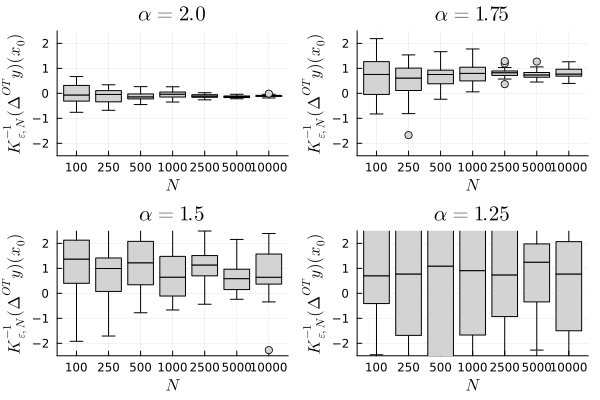

In [125]:
plot(plts_all...; ylim =(-2.5, 2.5))

In [148]:
for (α, plt) in zip([2.0, 1.75, 1.5, 1.25], plts_all)
    plot(plt; ylim = (-2.5, 2.5))
    savefig("../figures/qot_torus_alpha_$(α).pdf")
end

In [197]:
f1(x) = dot([3, 5, 7], x.^2 /2)
N = 5_000
X = vcat(x0', convert(Array, torusUnif(N, r, R)))'
C0 = 1.0
α = 1.5

y = map(f1, eachcol(X))
C = pairwise(SqEuclidean(), X)
C[diagind(C)] .= Inf
μ = fill(1/size(X, 2), size(X, 2));
ε = C0*N^α # pick exponent 3/2
K_eps_N = ε^(2/(d+2)) * N^(-4/(d+2))
# solve QOT
solver = OptimalTransport.build_solver(μ, C, ε, OptimalTransport.SymmetricQuadraticOTNewton(δ = 1e-5); maxiter = 25)
OptimalTransport.solve!(solver)
W = OptimalTransport.plan(solver) * size(X, 2)
L = I - W
-2*(L * y)[1] / K_eps_N

1.6538361988234915

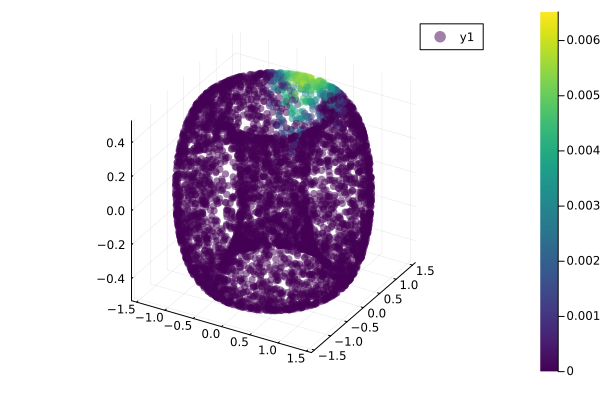

In [196]:
scatter(X[1, :], X[2, :], X[3, :]; marker_z = W[1, :], alpha = 0.5, markerstrokewidth = 0, color = :viridis, clim = (0, maximum(W)))

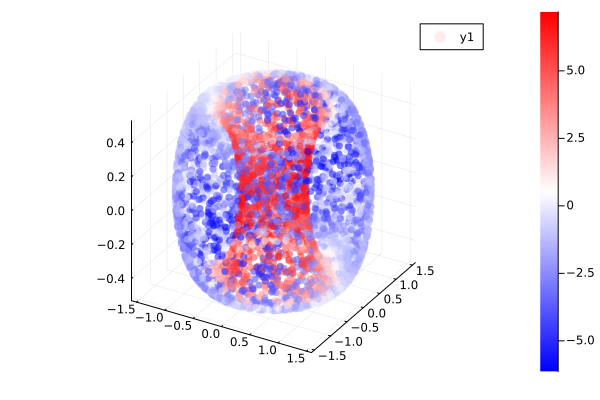

In [193]:
scatter(X[1, :], X[2, :], X[3, :]; marker_z = -2(L * y)/K_eps_N, color = :bwr, alpha = 0.5, markerstrokewidth = 0)

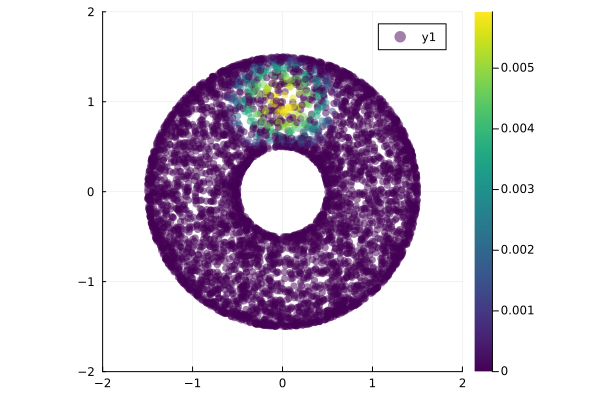

In [194]:
scatter(X[1, :], X[2, :]; marker_z = W[1, :], color = :viridis, alpha = 0.5, markerstrokewidth = 0, xlim = (-2, 2), ylim = (-2, 2), aspectratio = :equal)